In [122]:
import torch
from torch import nn, optim
from datetime import datetime

torch.manual_seed(123)

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Device {device}.")

Device cpu.


# INF265 Project 2: Object Detection

### Object localization tasks:

Loading the data:

In [123]:
train_path = 'data/localization_train.pt'
val_path = 'data/localization_val.pt'
test_path = 'data/localization_test.pt'

train_data = torch.load(train_path)
val_data = torch.load(val_path)
test_data = torch.load(test_path)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

(batch, labels) = next(iter(train_loader))

In [124]:
print(type(train_data))
print("Train data size: ", len(train_data))
print("Val data size: ", len(val_data))
print("Test data size: ", len(test_data))
print(train_data[0][0].shape)

img= batch[0]
print(img.shape)
print(labels[:,0])

<class 'torch.utils.data.dataset.TensorDataset'>
Train data size:  59400
Val data size:  6600
Test data size:  11000
torch.Size([1, 48, 60])
torch.Size([1, 48, 60])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0.])


tensor(1.)


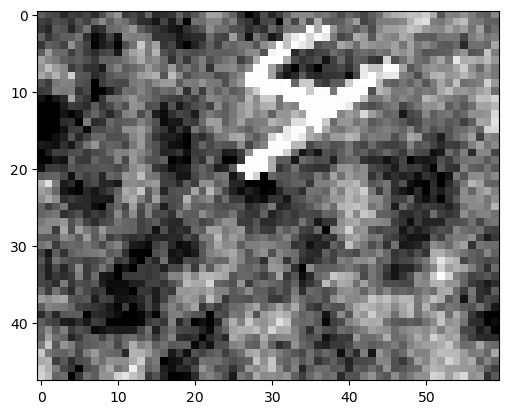

In [125]:
import matplotlib.pyplot as plt
img1, first_label = train_data[0]

plt.imshow(img1.squeeze().numpy(), cmap='gray')
print(first_label[0])

### My convolutional models:

In [126]:
class MyCNN1(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(

            # Conv layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Flatten the output to vector for the fully connected layer
            nn.Flatten(),
            
            # FC layers
            nn.Linear(32 * 24 * 30, 512),
            nn.Linear(512, 15)  # 15 outputs, 1 Pc + 4 bounding box vars + 10 classes
        )
    
    def forward(self, x):
        return self.cnn(x)

In [127]:
class MyCNN2(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(

            # Conv layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Flatten the output to vector for the fully connected layer
            nn.Flatten(),
            
            # FC layers
            nn.Linear(64 * 12 * 15, 256),
            nn.ReLU(),
            nn.Linear(256, 15)  # 15 outputs, 1 Pc + 4 bounding box vars + 10 classes
        )
    
    def forward(self, x):
        return self.cnn(x)

In [128]:
class MyCNN3(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(

            # Conv layer block 1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Flatten the output to vector for the fully connected layer
            nn.Flatten(),
            
            # FC layers
            nn.Linear(256 * 6 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 15)  # 15 outputs, 1 Pc + 4 bounding box vars + 10 classes
        )
    
    def forward(self, x):
        return self.cnn(x)

Loss function

In [134]:
# Uses different loss functions for different parts of the output.
def localization_loss(y_pred, y_true):
    
    BCE_loss = nn.BCEWithLogitsLoss()
    MSE_loss = nn.MSELoss()
    CE_loss = nn.CrossEntropyLoss()

  
    La = BCE_loss(torch.sigmoid(y_pred[:, 0]), y_true[:, 0])      # Loss function for our detection output: 'Pc'.
    Lb = MSE_loss(y_pred[:, 1:5], y_true[:, 1:5])                       # Loss function for our bounding box output: x, y, w, h.
    Lc = CE_loss(y_pred[:, 5:], y_true[:, 5].long())                    # Loss function for our class output: c1, c2, c3 ... c10.

    Pc = y_true[:, 0]
    empty_tensor = torch.tensor(0.0).to(y_pred.device)

    loss = La + torch.where(Pc == 1, La + Lb + Lc, empty_tensor) # Adds the Lb and Lc losses only if Pc is 1, otherwise adds the empty tensor.

    return loss.mean()

### Training

In [130]:
def train(model, loss_fn, lr, n_epochs, train_loader): 

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for i, data in enumerate(train_loader):

            x = data[0].to(device=device) 
            y_true = data[1].to(device=device)

            optimizer.zero_grad()

            y_pred = model(x)

            loss = loss_fn(y_pred, y_true)
            
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        print('{}  |  Epoch {} of {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, n_epochs, loss_train / n_batch))

In [29]:

models = [MyCNN1(), MyCNN2(), MyCNN3()]

lr = 0.005
n_epochs = 5
loss_fn = localization_loss

for model in models:
    print("----------------------------")
    print("Currently training: ", model)
    print("----------------------------")
    train(model, loss_fn, lr, n_epochs, train_loader)

    print("----------------------------")
    print("----------------------------\n\n\n")
    print()



----------------------------
Currently training:  MyCNN1(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=23040, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=15, bias=True)
  )
)
----------------------------
07:50:31.644220  |  Epoch 1  |  Training loss 2.75787
07:52:15.070353  |  Epoch 2  |  Training loss 2.67572
07:54:01.585544  |  Epoch 3  |  Training loss 2.59611
07:55:46.033098  |  Epoch 4  |  Training loss 2.48041
07:57:29.291155  |  Epoch 5  |  Training loss 2.35089
----------------------------
----------------------------




----------------------------
Currently training:  MyCNN2(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, 

### Evaluation and validation

In [131]:
def calculate_iou(pred_boxes, gt_boxes):

    pred_boxes = pred_boxes.float()
    gt_boxes = gt_boxes.float()
    
    # Calculate the coordinates of the intersection rectangles
    x1 = torch.max(pred_boxes[:, 0], gt_boxes[:, 0])
    y1 = torch.max(pred_boxes[:, 1], gt_boxes[:, 1])
    x2 = torch.min(pred_boxes[:, 2], gt_boxes[:, 2])
    y2 = torch.min(pred_boxes[:, 3], gt_boxes[:, 3])
    
    # Calculate intersection area
    inter_area = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    
    # Calculate the area of both prediction and ground truth boxes
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    gt_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])
    
    # Calculate the union area
    union_area = pred_area + gt_area - inter_area
    
    # Calculate the IoU
    iou = inter_area / union_area
    
    return iou

In [148]:
val_data
val_loader

performance = {}

for i, model in enumerate(models):
    model.eval()  # Ensure the model is in evaluation mode
    total_loss = 0.0
    classification_correct_predictions = 0
    object_presence_correct_predictions = 0
    total_iou = 0.0
    total_predictions = 0

    with torch.no_grad():
        for input, labels in val_loader:
            input = input.to(device)
            # Assuming labels is a list or a custom object containing 
            # class labels, bounding boxes, and object presence
            presence_labels = labels[:, 0].long().to(device)
            bbox_labels = labels[:, 1:5].to(device)
            class_labels = labels[:, 5].long().to(device)

            outputs = model(input)  # Forward pass
            
            # Assuming outputs is a dict with keys 'classes', 'bboxes', and 'presence'
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            # Evaluate classification accuracy
            _, predicted_classes = torch.max(outputs[:, 5:].data, 1)
            classification_correct_predictions += (predicted_classes == class_labels).sum().item()
            print(labels.shape)
            print(labels[0].shape)
            print(outputs[:, 0])
            #sig = torch.sigmoid(outputs[: 0])
            #print("SIGMOID: ", sig)
            # Evaluate object presence accuracy
            predicted_presence = torch.sigmoid(outputs[: 0]).data > 0.5  # Assuming sigmoid output
            object_presence_correct_predictions += (predicted_presence == presence_labels).sum().item()

            # Evaluate bounding box accuracy using IoU or similar
            iou_scores = calculate_iou(outputs[:, 1:5], bbox_labels)  # Implement calculate_iou
            total_iou += iou_scores.sum().item()
            
            total_predictions += class_labels.size(0)

        avg_loss = total_loss / len(val_loader)
        classification_accuracy = classification_correct_predictions / total_predictions
        presence_accuracy = object_presence_correct_predictions / total_predictions
        avg_iou = total_iou / total_predictions
        
        print(f"Validation Loss: {avg_loss:.4f}, Classification Accuracy: {classification_accuracy:.4f}, "
            f"Presence Accuracy: {presence_accuracy:.4f}, Average IoU: {avg_iou:.4f}")



# I sort by accuracy here.performance[i] = (avg_loss, accuracy)
sorted_performance = sorted(performance.items(), key=lambda item: item[1][1], reverse=True)

best_model = models[sorted_performance[0][0]] # I choose the model with the highest accuracy.



torch.Size([64, 6])
torch.Size([6])
tensor([ 7.2748, -0.1217,  1.9214,  5.0960,  4.9294,  2.3683,  2.0871,  3.1977,
         2.8330,  2.6254,  2.0846,  1.8124,  3.4861,  1.7220,  4.8630,  2.3928,
         1.4632,  4.2888,  1.0453,  2.8359,  2.5183,  3.1654,  1.0635,  4.5826,
         1.9050,  2.7777,  2.5278,  5.2212,  4.6836,  4.0635,  5.3824,  3.7673,
        -0.5406,  4.0735,  2.6532,  3.7840,  2.7444,  0.1742,  2.0202,  4.9920,
         1.5056,  2.5759,  3.7132,  3.8764,  5.0151,  4.6158,  2.7759,  4.3476,
         4.1491,  4.0125,  5.3803,  1.2441, -0.8776,  0.6744,  4.2997,  2.8566,
         3.2157,  5.8529,  3.2682, -0.7949,  4.6902,  4.2847,  3.0222,  4.7143])
SIGMOID:  tensor([], size=(0, 15))


RuntimeError: The size of tensor a (15) must match the size of tensor b (64) at non-singleton dimension 1

In [78]:
lis = list(range(10))
print(lis[5:])

[5, 6, 7, 8, 9]


### Best Model


In [ ]:
best_model.eval()

total_loss = 0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for input, labels in test_loader:

        input = input.to(device)  
        labels = labels.to(device)
        
        outputs = best_model(input)  #The forward pass
        
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate average loss and total accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

In [52]:
img, label = test_data[0]
print(label[:-1])

tensor([1.0000, 0.4000, 0.2188, 0.2667, 0.2292])


### Drawing boxes

In [ ]:
from torchvision.transforms.functional import to_pil_image
from PIL import ImageDraw

img, label = test_data[0]

img_pil = to_pil_image(img)

outputs = best_model(img)
Pc1, x1, y1, w1, h1 = label[:5]
Pc2, x2, y2, w2, h2 = outputs[:5]

bbox_true = (x1, y1, x1 + w1, y1 + h1)
bbox_pred = (x2, y2, x2 + w2, y2 + h2)






draw = ImageDraw.Draw(img_pil)
draw.rectangle(bbox_true, outline="yellow", width=3)
draw.rectangle(bbox_pred, outline="red", width=3)

# Display the image
img_pil.show()



### Object detection tasks

In [102]:
#train_path = 'data/list_y_true_train.pt'
#val_path = 'data/list_y_tru_val.pt'
#test_path = 'data/list_y_tru_test.pt'

train_path = 'data/detection_train.pt'
val_path = 'data/detection_val.pt'
test_path = 'data/detection_test.pt'

train_data = torch.load(train_path)
val_data = torch.load(val_path)
test_data = torch.load(test_path)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


### Train

In [103]:
class MyNewCNN1(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(

            # Conv layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Replaced layers
            nn.Conv2d(in_channels=32, out_channels=15, kernel_size=1, stride=1, padding=0)
        )
    
    def forward(self, x):
        return self.cnn(x)

In [104]:
class MyNewCNN2(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(

            # Conv layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Replaced layers
            nn.Conv2d(in_channels=64, out_channels=15, kernel_size=1, stride=1, padding=0)
        )
    
    def forward(self, x):
        return self.cnn(x)

In [105]:
class MyNewCNN3(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(

            # Conv layer block 1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Replaced layers
            nn.Conv2d(in_channels=256, out_channels=15, kernel_size=1, stride=1, padding=0)
        )
    
    def forward(self, x):
        return self.cnn(x)

In [ ]:
models = [MyNewCNN1(), MyNewCNN2(), MyNewCNN3()]

lr = 0.005
n_epochs = 5
loss_fn = localization_loss

for model in models:
    print("----------------------------")
    print("Currently training: ", model)
    print("----------------------------")
    train(model, loss_fn, lr, n_epochs, train_loader)

    print("----------------------------")
    print("----------------------------\n\n\n")

### Best Model

#### Draw boxes